In [306]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import gaussian_kde
import os
import yaml
import h5py
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import time

import warnings

In [307]:
import sys
sys.path.append(r'../tools_F-J/')
sys.path.append(r'../tools_F-J/toollib_DisbaCode')
from objective_function import (ObjectiveFunctionDerivativeUsed, Forward)
from toollib_DisbaCode import forward
from toollib_DisbaCode import objective_function
from toollib_DisbaCode import empirical_relation
from toollib_DisbaCode import plot_disp
from toollib_DisbaCode import plot_model
from toollib_DisbaCode import plot_lcurve
from toollib_DisbaCode import plot_inversion    
from toollib_DisbaCode import plot_kernel

#from toollib_standard import maplib
#from toollib_standard import mathlib
#from toollib_standard import filelib
#from toollib_standard import stacklib
from toollib_standard import plotlib

In [308]:
flag_project = 1 # 0--regular; 1--repartrition; 2--voronoi
flag_mode = 2 # 0--fundamental; 1--Overtones; 2--Both
flag_forward = 1 # 0--no forward calculation; 1--forward calculation
file_init = 'initial/initial_model_4.txt'

In [309]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [310]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_03--10-16Hz/


In [311]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [312]:
dir_ds = dir_project + info_basic['rdir_ds']
dir_partition = dir_project + info_basic['rdir_partition']
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
f0 = info_basic_bi['f']
c = np.linspace(info_basic['fj_c_min'], info_basic['fj_c_max'], info_basic['fj_c_num'])

In [313]:
#filename = dir_project+info_basic['rdir_inv_BFGS']+'inv2.txt'
#nums = np.loadtxt(filename,dtype=int)
#nums = [str(x) for x in nums]
nums = [277] 
key_subworks_all = info_basic['key_subworks']
key_subworks = []
for num in nums:
    for key_subwork in key_subworks_all:
        if str(num) == key_subwork.split('--')[0]:
            key_subworks.append(key_subwork)
            break
#key_subworks = info_basic['key_subworks']
key_subworks

['277--26-10']

In [314]:
file_config_fund = 'config_inv_fund.yml'
file_config = 'config_inv.yml'

In [315]:
if flag_mode == 0:
    dir_image = dir_project +  info_basic['rdir_image'] + 'inversion_fund/'
elif flag_mode == 1:
    dir_image = dir_project +  info_basic['rdir_image'] + 'inversion_over/'
elif flag_mode == 2:
    dir_image = dir_project +  info_basic['rdir_image'] + 'inversion_compare/'
else: 
    print('Mode error')
    exit()

if not os.path.exists(dir_image):
    os.mkdir(dir_image)

if flag_mode != 0:
    info_basic['rdir_BFGS_invfile'] = info_basic['rdir_inv_BFGS'] + 'inversion/'
    info_basic['rdir_disp_model'] = info_basic['rdir_inv_BFGS'] + 'disp_model/'
    info_basic['rdir_model'] = info_basic['rdir_inv_BFGS'] + 'model/'
    dir_invfile = dir_project + info_basic['rdir_BFGS_invfile']
    dir_disp_model = dir_project + info_basic['rdir_disp_model']
    dir_model = dir_project + info_basic['rdir_model']

    if not os.path.exists(dir_invfile):
        os.mkdir(dir_invfile)
    if not os.path.exists(dir_disp_model):
        os.mkdir(dir_disp_model)
    if not os.path.exists(dir_model):
        os.mkdir(dir_model)
if flag_mode !=  1:
    info_basic['rdir_BFGS_invfile_fund'] = info_basic['rdir_inv_BFGS'] + 'inversion_fund/'
    info_basic['rdir_disp_model_fund'] = info_basic['rdir_inv_BFGS'] + 'disp_model_fund/'
    info_basic['rdir_model_fund'] = info_basic['rdir_inv_BFGS'] + 'model_fund/'
    dir_invfile_fund = dir_project + info_basic['rdir_BFGS_invfile_fund']
    dir_disp_model_fund = dir_project + info_basic['rdir_disp_model_fund']
    dir_model_fund = dir_project + info_basic['rdir_model_fund']
    if not os.path.exists(dir_invfile_fund):
        os.mkdir(dir_invfile_fund)
    if not os.path.exists(dir_disp_model_fund):
        os.mkdir(dir_disp_model_fund)
    if not os.path.exists(dir_model_fund):
        os.mkdir(dir_model_fund)

### Read data

In [316]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 

In [317]:
# fault surface trace
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [318]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
for key in info_basic['key_subworks']:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [319]:
ds_all = {}
for key in key_subworks:
    print(key+ ' '+str(key_subworks.index(key)+1) + '/'+str(len(key_subworks)))
    ds = h5py.File(dir_ds+'ds_'+key+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    ds_all[key] = plotlib.smooth_ds(ds_remove)

277--26-10 1/1


### Forard and plot estimated disp and Vs

In [320]:
def plot_fj(ax,ds_linear,title0,f,c,index,v_min,v_max,c_map):
    ax.imshow(np.flip(ds_linear,0),aspect='auto',extent=[min(f),max(f),min(c),max(c)],vmin=v_min,vmax = v_max, cmap = c_map)
    #plt.imshow(np.flip(ds_linear,0),extent=[min(f),max(f),min(c),max(c)],aspect='auto',cmap='jet',vmin=0,vmax=1)
    #ax.pcolormesh(f,c,ds_linear,cmap='jet',vmin=0,vmax=1)
    if index == 0:
        ax.set_title(title0)
    else:
        ax.set_title('('+chr(96+index)+')',loc='left')
    ax.set_xlabel('Normalized Frequency/ Hz')
    ax.set_ylabel('Velocity/ m/s')
    #ax.set_xlim(xlim)
    return ax

### Plot parameters

In [321]:
with open(dir_inv+file_config, 'r') as fp:
    config = yaml.safe_load(fp)
with open(dir_inv+file_config_fund, 'r') as fp:
    config_fund = yaml.safe_load(fp)

c_map = 'jet'
v_max = None
v_min = 0.1

all_disp = 0
show_std = 1
show_init = 0
plot_fund = 1
xlim_f = [0.5,30]
xlim_T = [-1,1]
ylim_c = [0.25,1.8]
clim = [0,1]
fmin = 1
fmax = 30
cmin = 0.1
cmax = 2.5
vmax = 0.3

max_mode = 4

In [322]:
if flag_mode != 0:
    num_row = 3
    num_col = 3
else:
    num_row = 3
    num_col = 2

277--26-10, 1/1


elapsed time:     0.612
elapsed time:     0.558


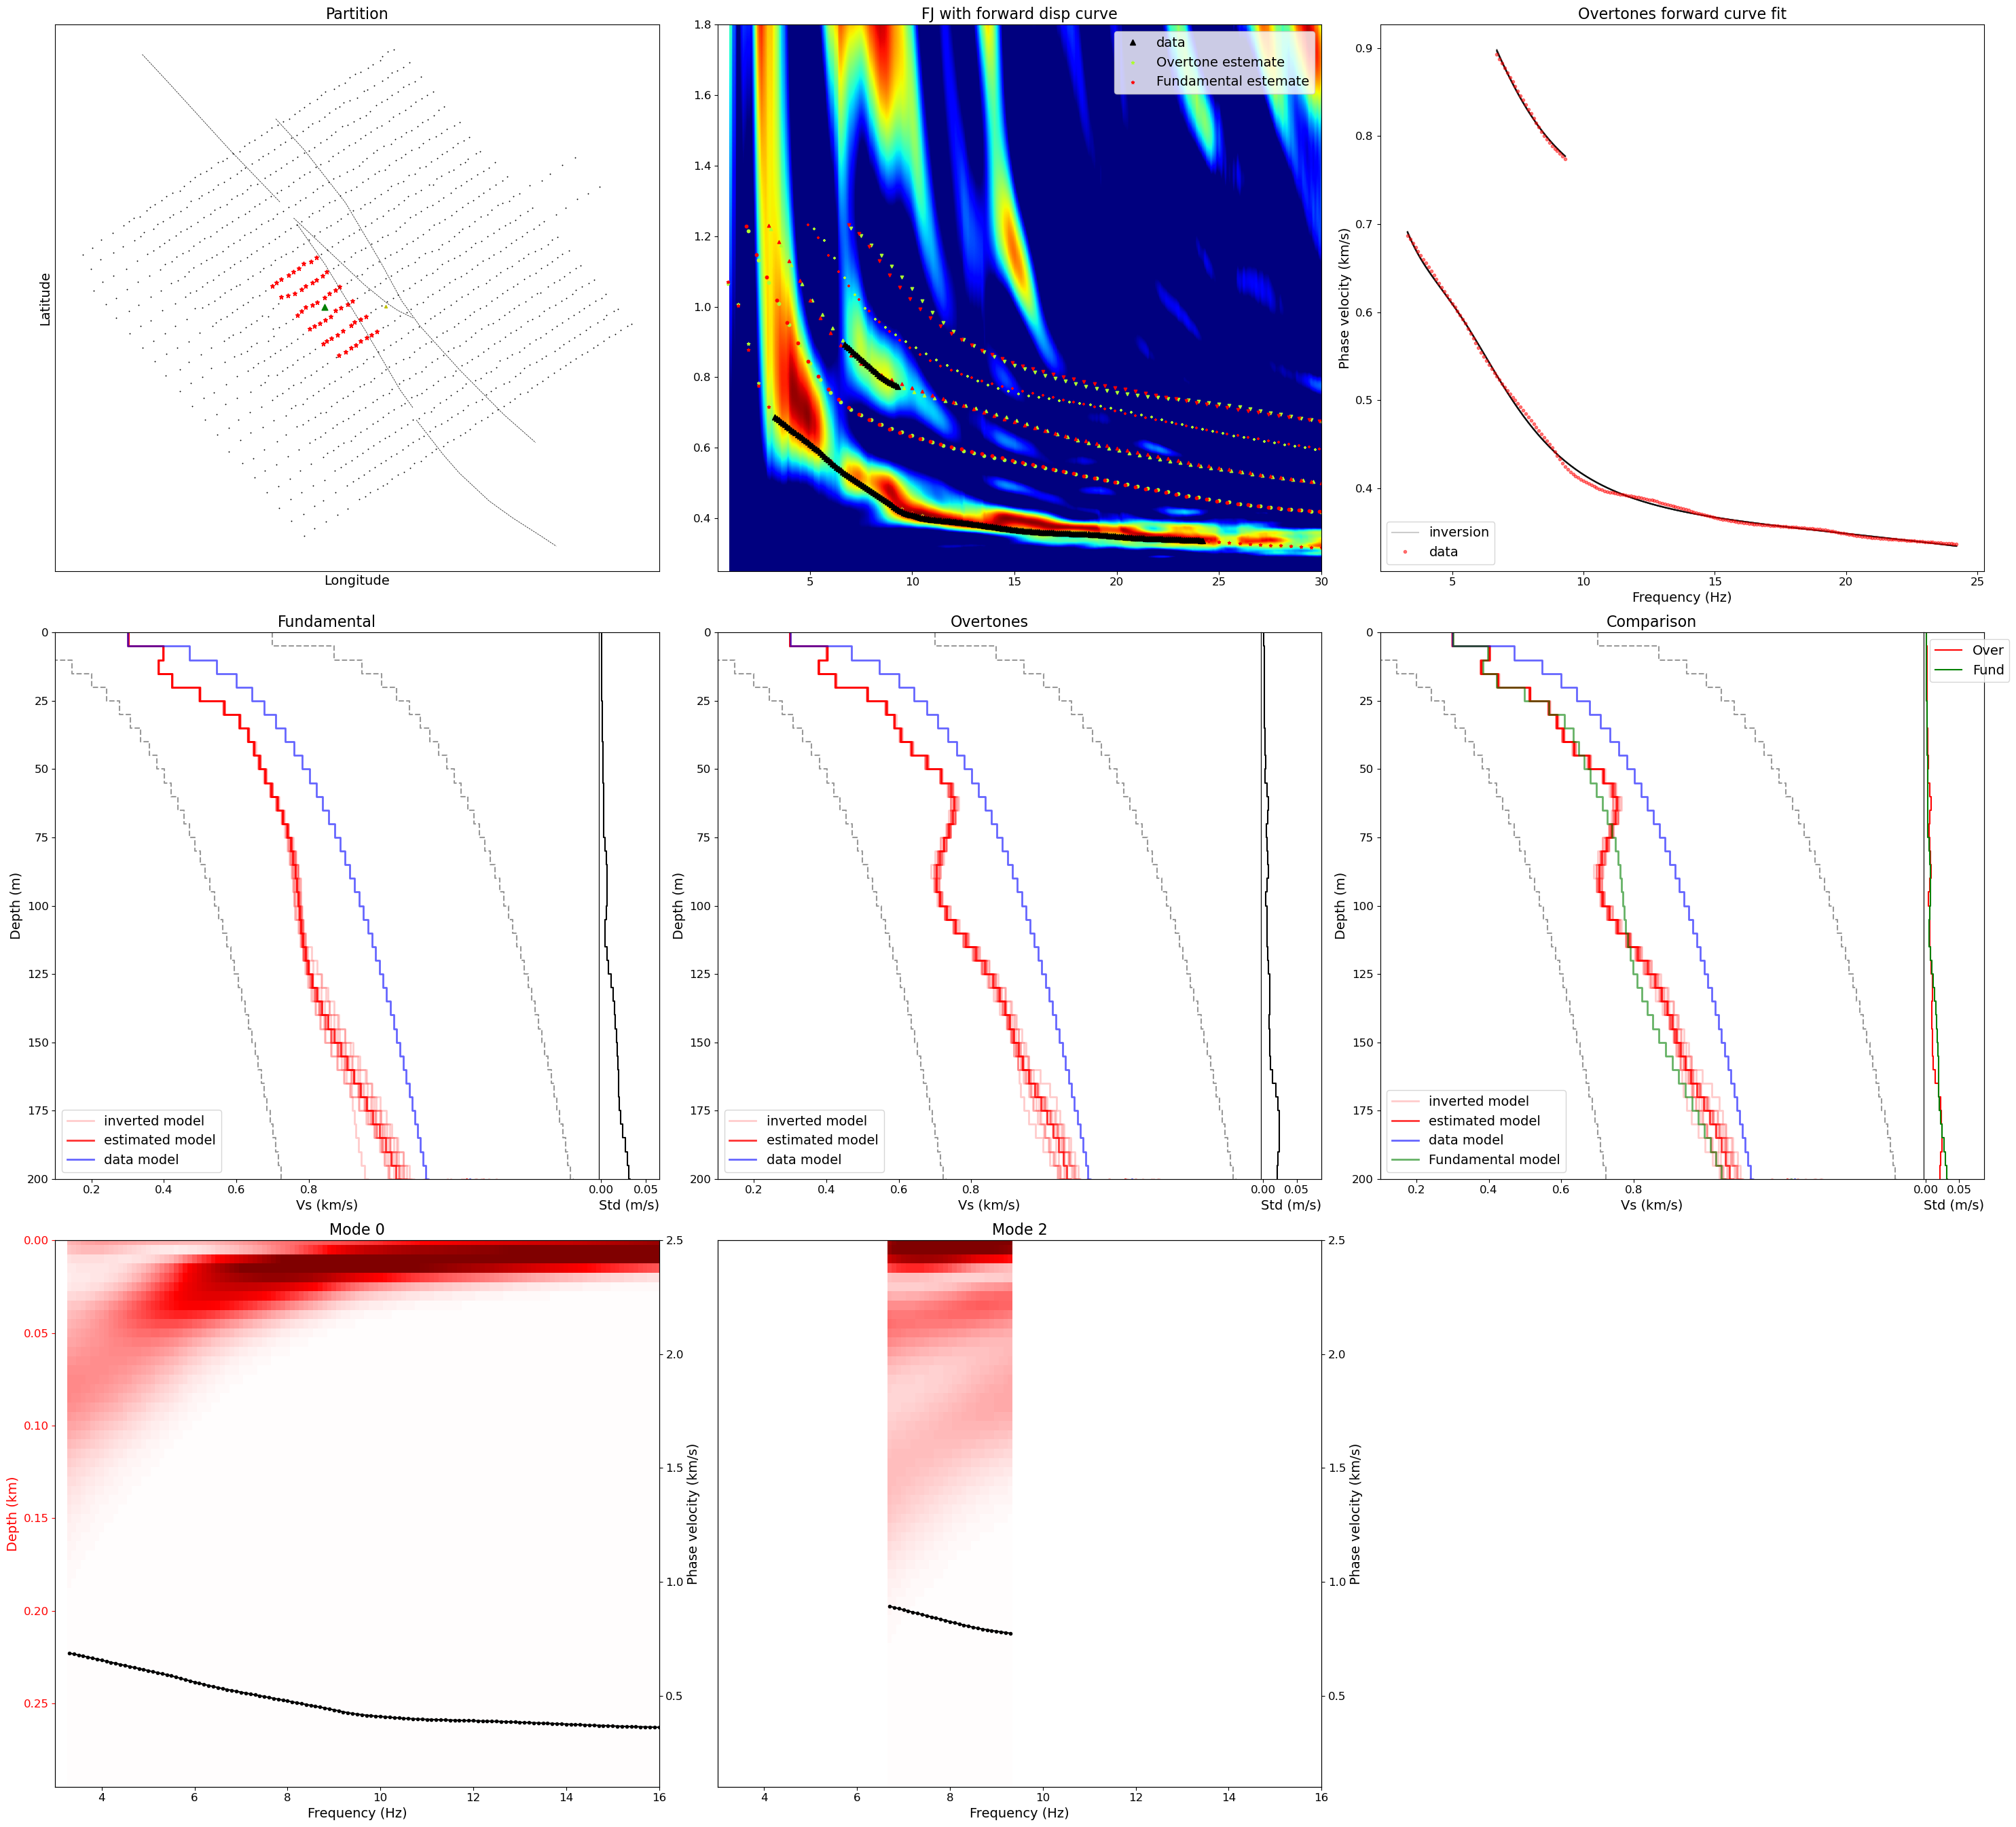

In [323]:
flag_num = 0
inter_forward = 5
linestyle = ['*','o','^','+','v','<','>','p','h']
for key_subwork in key_subworks:
    flag_num += 1
    print(key_subwork + ', '+str(key_subworks.index(key_subwork)+1) + '/' + str(len(key_subworks)) ) 

    # configuration
    file_inv =  'ds_'+key_subwork+'curve'
    file_disp_data = dir_project + info_basic['rdir_disp_pick']+'ds_'+key_subwork+'curve.txt'
    if flag_mode != 0:
        file_model = 'model_'+key_subwork+'.txt'
        file_disp_forward = dir_disp_model +  'disp_model_'+key_subwork+'.txt'
        if not os.path.exists(dir_invfile+file_inv):
            print(key_subwork+'Overtone inversion data file not exist')
            plt.close()
            continue
    if flag_mode != 1: 
        file_model_fund = 'model_'+key_subwork+'.txt'
        file_disp_forward_fund = dir_disp_model_fund +  'disp_model_'+key_subwork+'.txt'
        if not os.path.exists(dir_invfile_fund+file_inv):
            print(key_subwork+' Fundamental inversion data file not exist')
            plt.close()
            continue    
    ds_remove = ds_all[key_subwork]
    
    if flag_mode == 0:
        fig = plt.figure(figsize=(20,18))
    else: 
        fig = plt.figure(figsize=(30,27))
        
    # plot partition
    stalist = stations_partition[key_subwork]
    lat_stations_this = lat_stations_partition[key_subwork]
    lon_stations_this = lon_stations_partition[key_subwork]
    ax_partition = fig.add_subplot(num_row,num_col,1)
    ax_partition=plotlib.plot_area(ax_partition,lon_stations_all,lat_stations_all,lon_stations_this,lat_stations_this,markersize = 0.75 ,markersize2 = 5)
    ax_partition.scatter(lon_centroid_partition,lat_centroid_partition,marker='^',color='y',s=8)
    for i in range(len(faults)):
        ax_partition.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw = 0.5)
    ax_partition.scatter(np.mean(lon_stations_this),np.mean(lat_stations_this),marker='^',color='g',s=40)
    ax_partition.set_title('Partition')

    # plot velocity structure
    for i in range(flag_mode+1):
        if flag_mode != 2:
            if i != flag_mode:
                continue
        axes = fig.add_subplot(num_row,num_col,4+i)
        axes.set_xticks([])  #去掉横坐标值
        axes.set_yticks([])  #去掉纵坐标值
        if show_std == 1:
            ax_struc = axes.inset_axes([0,0,0.9,1])
            ax_std = axes.inset_axes([0.9,0,0.1,1])
            xtick = ax_struc.get_xticks()
            xtick = xtick[:-1]
            ax_struc.set_xticks(xtick)
            ax_std.set_yticks([])  #去掉纵坐标值
            ax_std.set_ylim([0,config['plot']['zmax']])
            ax_std.set_xlabel('Std (m/s)')
            ax_std.invert_yaxis()  #y轴反向
        else:
            ax_struc = axes.inset_axes([0,0,1,1])
        if i == 0:
            ax_struc,model_fund,fmt = plot_inversion.plot_model(config_fund, file_inv, show_init, file_model_fund,file_init,ax_struc,dir_this = dir_inv)
            std_fund = model_fund[:,5]
            z_step = model_fund[:,1]
            if show_std == 1:
                ax_std.step(std_fund,z_step,'k',label='Fund')
            np.savetxt(dir_model_fund+file_model_fund, model_fund, fmt=fmt)
            ax_struc.set_title('Fundamental')
        if i == 1:
            ax_struc,model,fmt = plot_inversion.plot_model(config, file_inv, show_init, file_model,file_init,ax_struc,dir_this = dir_inv)
            std = model[:,5]
            z_step = model[:,1]
            if show_std == 1:
                ax_std.step(std,z_step,'k',label='Over')
            np.savetxt(dir_model+file_model, model, fmt=fmt)
            ax_struc.set_title('Overtones') 
        if i == 2:
            ax_struc,model,fmt = plot_inversion.plot_model(config, file_inv, show_init, file_model,file_init,ax_struc,file_model_fund =dir_model_fund + file_model_fund,plot_fund=1,dir_this = dir_inv)
            if show_std == 1:
                ax_std.step(std,z_step,'r',label = 'Over')
                ax_std.step(std_fund,z_step,'g',label='Fund')
                ax_std.legend()
            ax_struc.set_title('Comparison')

    # forward calculation
    if flag_forward == 1:
        if flag_mode != 1:
            forward.forward_cal(info_basic,max_mode,dir_model_fund+file_model_fund,file_disp_forward_fund)
        if flag_mode != 0:
            forward.forward_cal(info_basic,max_mode,dir_model+file_model,file_disp_forward)

    # plot fit curve
    ax_fit = fig.add_subplot(num_row,num_col,3)
    if flag_mode == 0:
        ax_fit = plot_inversion.plot_disp(config_fund, file_inv, all_disp,ax_fit,dir_this = dir_inv)
        ax_fit.set_title('Fundamental forward curve fit')
    else:
        ax_fit = plot_inversion.plot_disp(config, file_inv, all_disp,ax_fit,dir_this = dir_inv)
        ax_fit.set_title('Overtones forward curve fit')

    # plot FJ with forward disp curve
    title0 = "FJ with forward disp curve"
    ax_FJ = fig.add_subplot(num_row,num_col,2)
    ax_FJ.set_xlim(xlim_f)
    ax_FJ.set_ylim(ylim_c)
    ax_FJ = plotlib.plot_fj(ax_FJ,ds_remove,title0,f0,c,0,v_min = v_min,v_max=v_max,c_map=c_map)
    disp_data = np.loadtxt(file_disp_data)
    num_m_data = len(set(disp_data[:,2]))
    modes_data = set(disp_data[:,2].astype(int))
        # data
    for mode in modes_data:
        data_mode = disp_data[disp_data[:, 2] == mode]
        if mode==0:
            ax_FJ.plot(data_mode[:, 0], data_mode[:, 1], 'k^',label='data',linewidth=4)
        else:
            ax_FJ.plot(data_mode[:, 0], data_mode[:, 1],  'k^',linewidth=4 )
        # foward
    if flag_mode != 0:
        file_disp_forward = dir_disp_model +  'disp_model_'+key_subwork+'.txt'
        disp_forward = np.loadtxt(file_disp_forward)
        num_m = len(set(disp_forward[:,2]))
        modes = set(disp_forward[:,2].astype(int))
        for mode in modes:
            disp_forward_mode = disp_forward[disp_forward[:, 2] == mode]
            if mode==0:
                ax_FJ.scatter(disp_forward_mode[::inter_forward, 0], disp_forward_mode[::inter_forward, 1], color='greenyellow',marker = linestyle[mode],label='Overtone estemate',s=10)
            else:
                ax_FJ.scatter(disp_forward_mode[::inter_forward, 0], disp_forward_mode[::inter_forward, 1], color='greenyellow',marker = linestyle[mode],s=10)
    if flag_mode != 1:
        file_disp_forward_fund = dir_disp_model_fund +  'disp_model_'+key_subwork+'.txt'
        disp_forward_fund = np.loadtxt(file_disp_forward_fund)
        num_m = len(set(disp_forward_fund[:,2]))
        modes = set(disp_forward_fund[:,2].astype(int))
        for mode in modes:
            disp_forward_fund_mode = disp_forward_fund[disp_forward_fund[:, 2] == mode]
            if mode==0:
                ax_FJ.scatter(disp_forward_fund_mode[::inter_forward, 0], disp_forward_fund_mode[::inter_forward, 1], color='red',marker = linestyle[mode],label='Fundamental estemate',s=10)
            else:
                ax_FJ.scatter(disp_forward_fund_mode[::inter_forward, 0], disp_forward_fund_mode[::inter_forward, 1], color='red',marker= linestyle[mode],s=10)
    ax_FJ.legend()

    # plot kernel
    fmin_kernel = 3
    fmax_kernel = 16
    if flag_mode == 0:
        ax_kernel = fig.add_subplot(num_row,num_col,5)
        ax_kernel = plot_kernel.kernel_plot(fmin_kernel,fmax_kernel,cmin,cmax,file_disp_data,dir_model_fund+file_model_fund,0,vmax,ax_kernel)
    else:
        flag = 0
        for mode in modes_data:
            if len(modes_data) > 2:
                ax_kernel = fig.add_subplot(num_row,num_m_data,(num_row-1)*num_m_data+1+flag)
            else:
                ax_kernel = fig.add_subplot(num_row,num_col,(num_row-1)*num_col+1+flag)
            ax_kernel = plot_kernel.kernel_plot(fmin_kernel,fmax_kernel,cmin,cmax,file_disp_data,dir_model+file_model,mode,vmax,ax_kernel)
            ax_kernel.set_title('Mode '+str(mode))
            if flag != 0:
                ax_kernel.set_yticks([])
                ax_kernel.set_ylabel('')    
            flag += 1
    
    plt.tight_layout()
    #plt.savefig(dir_image+key_subwork+'_inversion.png')
    #plt.close()

In [324]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)